# Running Parallel Jobs on JupyterHub in R
Author: Zach Schira

[JupyterHub](https://jupyterhub.readthedocs.io/en/latest/) offers a multi user environment for running Jupyter Notebooks. Research Computing provides access to a JupyterHub environment with parallel processing support. This tutorial will demonstrate how to use the [parallel](https://stat.ethz.ch/R-manual/R-devel/library/parallel/doc/parallel.pdf) R package to run simple parallel jobs within the R kernel on JupyterHub. 

## Objectives

- Connect to a remote cluster for parallel processing
- Use the parallel package to run jobs

## Dependencies

- parallel

## Setup and basic use

First you must connect to a cluster where you will be doing your parallel processing. In this example, we will just be using the cores available on your local machine, but if you are running your job through JupyterHub, you can use any of the RC resources described [here](https://www.rc.colorado.edu/support/user-guide/jupyterhub.html).

In [1]:
options(jupyter.plot_mimetypes = 'image/png')
options(jupyter.rich_display=FALSE)

library(parallel)

num_cores <- detectCores()
cl <- makeCluster(num_cores)

The parallel package contains functions that mirror the base R [lapply](http://www.inside-r.org/r-doc/base/sapply) function. The following example will calculate the square of each number in a sequence in parallel.

In [2]:
square <- function(x) {
    x^2
}
parSapply(cl, 1:10, square)

 [1]   1   4   9  16  25  36  49  64  81 100

## Evaluating expressions in parallel with `clusterEvalQ`

The `clusterEvalQ` function can be used include R packages into each node of your cluster. 
More generally, `clusterEvalQ` evaluates expressions within each node.
For instance, let's say you wanted to simulate draws from a negative binomial distribution using the `rnegbin` function in the `MASS` package. 
To make the function available to each node, `clusterEvalQ` evaluates the expression `library(MASS)` on each node:

In [3]:
clusterEvalQ(cl, library(MASS))

[[1]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     


A list is printed with one element per node, showing the packages that are loaded.

While `clusterEvalQ` evaluates literal expressions on each node, `clusterExport` can export objects to the global environment of each node. For instance, if we want to have each node generate 1000 samples from a negative binomial distribution, we can do the following:

In [4]:
nb_draws <- clusterEvalQ(cl, rnegbin(n = 1000, mu = 2, theta = .3))
str(nb_draws)

List of 4
 $ : int [1:1000] 0 0 0 0 3 0 1 1 8 0 ...
 $ : int [1:1000] 0 5 0 1 0 9 1 1 5 1 ...
 $ : int [1:1000] 1 0 0 0 3 0 2 0 1 11 ...
 $ : int [1:1000] 0 1 0 0 0 1 2 0 0 7 ...


Now we have draws from a negative binomial distribution for each node. 
Let's visualize the cumulative distribution function (CDF) for each of the samples.

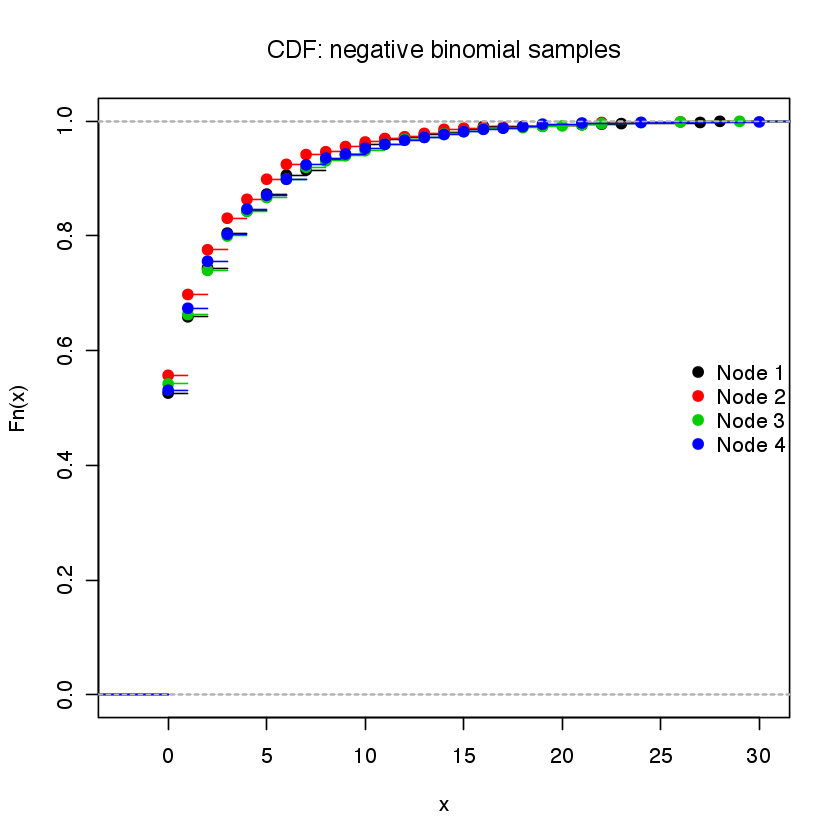

In [5]:
plot(ecdf(nb_draws[[1]]), main = 'CDF: negative binomial samples')
for (i in 2:num_cores){
    plot(ecdf(nb_draws[[i]]), add = TRUE, col = i)
}
core_seq <- 1:num_cores
legend('right', col = core_seq, 
      legend = paste('Node', core_seq), 
      pch = 19, bty = 'n')

## Parallel versions of `lapply` and `sapply` with built-in and custom functions

If we have a list of values, we can apply functions to the elements of the list in parallel using `parSapply` or `parLapply`. 
With our list `nb_draws`, we can calculate a sample means for each set of draws by applying the `mean` function over the list of simulations. 

In [6]:
parSapply(cl, nb_draws, mean)

[1] 2.082 1.825 2.120 2.085

Let's compare the time it takes to do these operations 10000 times in serial vs. in parallel. In this case, we're calling a user defined function `get_nb_mean`.

In [7]:
get_nb_mean <- function(i = NULL, pars) {
    # i is a dummy argument
    
    # unroll parameters
    n <- pars[1] 
    mu <- pars[2]
    theta <- pars[3]
    
    # draw a sample and compute the mean
    x <- MASS::rnegbin(n, mu, theta)
    mean(x)
}

n_replicates <- 10000
pars <- c(n = 1000, mu = 2, theta = .3)

# serially
system.time({
  serial_vals <- replicate(n_replicates, get_nb_mean(pars = pars))  
})

# in parallel
system.time({
    par_vals <- parSapply(cl, 1:n_replicates, get_nb_mean, pars = pars)    
})

   user  system elapsed 
  2.089   0.020   2.120 

   user  system elapsed 
  0.006   0.001   0.567 

With four cores working in parallel, these operations are about 3.5 times faster! (Though we might expect 4x speed improvements, there is overhead associated with the parallel operations that prevents a full 4x speedup).

Note that in our custom function, we specified a dummy argument `i` which is never used inside of the function definition. 
This is still useful however as a means for implementing a parallel version of the `replicate` function, because we can apply our function over a vector of integer values (in this case `1:n_replicates`), but the value of `i` has no effect on the output of `get_nb_mean()`.
For large iterative simulations applied over clusters, the [`iterators`](https://cran.r-project.org/web/packages/iterators/index.html) package can also be used. 

Once you have finished, run the `stopCluster` function to free up resources.

In [8]:
stopCluster(cl)